In [3]:
using Pkg
#Pkg.add("RigidBodyDynamics")
#Pkg.add("MeshCat")
#Pkg.add("MeshCatMechanisms")
#Pkg.add("StaticArrays")
#Pkg.add("Rotations")
#Pkg.add("ForwardDiff")
#Pkg.add("FiniteDiff")
#Pkg.add("Quaternions")
#Pkg.add("OSQP")
#Pkg.add("Plots")
#Pkg.add("Colors")
#Pkg.add("MathOptInterface")
#Pkg.add("Ipopt")
#Pkg.add("GeometryBasics")
#Pkg.add("CoordinateTransformations")
include(joinpath(@__DIR__, "humanoid.jl"))
include(joinpath(@__DIR__, "ball_qp.jl"))
using LinearAlgebra
import ForwardDiff as FD
using GeometryBasics

WebIO._IJuliaInit()

## Finding Robot Balancing Pose

In [5]:
model = G1Humanoid()
mech = model.mech
const x_guess = initial_state(model) # our guess state for balancing
mvis = initialize_visualizer(model) # visualizer 
set_configuration!(mvis, x_guess[1:state_dim(model)÷2])
foot_pos = get_right_foot_tip_location(mech, x_guess)
println("Foot tip position: ", foot_pos)

# Add red sphere at foot location
foot_point = mvis.visualizer["foot_point"]
setobject!(
    foot_point, 
    HyperSphere(Point3f(foot_pos), Float32(0.01))  # Both Float32
)
setprop!(foot_point, "color", RGB(1, 0, 0))  # Red color
render(mvis)

Foot tip position: 

[ Info: Listening on: 127.0.0.1:8715, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8715


[-0.4539735038572158, -0.19194453008619367, 0.2135702686910089]


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("foot_point" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74], nothing, Dict{String, Vector{UInt8}}("color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dummy2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6d, 0x79, 0x31, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_roll_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_8" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65,

In [ ]:
function linesearch(z::Vector, Δz::Vector, merit_fx::Function;
                    max_ls_iters = 10)::Float64 # optional argument with a default

    α = 1
    for i = 1:max_ls_iters
        
        if (merit_fx(z + α * Δz) < merit_fx(z))
            return α
        end
        α = α / 2
        
    end
    error("linesearch failed")
end

function newtons_method(z0::Vector, res_fx::Function, res_jac_fx::Function, merit_fx::Function;
                        tol = 1e-10, max_iters = 50, verbose = false)::Vector{Vector{Float64}}
    
    # Computes Newton's method given the following inputs:
    # - z0, initial guess 
    # - res_fx, residual function 
    # - res_jac_fx, Jacobian of residual function wrt z 
    # - merit_fx, merit function for use in linesearch 
    
    # optional arguments 
    # - tol, tolerance for convergence. Return when norm(residual)<tol 
    # - max iter, max # of iterations 
    # - verbose, bool telling the function to output information at each iteration
    
    # return a vector of vectors containing the iterates 
    # the last vector in this vector of vectors should be the approx. solution 
    
    # return the history of guesses as a vector
    Z = [zeros(length(z0)) for i = 1:max_iters]
    Z[1] = z0 
    
    for i = 1:(max_iters - 1)        
        r = res_fx(Z[i]) 
        
        norm_r = norm(r) 
        if verbose 
            print("iter: $i    |r|: $norm_r   ")
        end
        
        # if converged, return Z[1:i]
        if norm_r < tol
            return Z[1:i]
        end
        
        Δz = -1 *  res_jac_fx(Z[i]) \ res_fx(Z[i])
        
        α = linesearch(Z[i], Δz, merit_fx)

        Z[i+1] = Z[i] .+ α*Δz

        if verbose
            print("α: $α \n")
        end
        
    end
    error("Newton's method did not converge")
end
function merit(z)
    # merit function
    r = kkt(z)
    return norm(r[1:94]) + 1e4*norm(r[94:end])
end

In [ ]:
# initial guess 
const x_guess = initial_state(model)

# indexing stuff 
const idx_x = 1:64
const idx_u = 65:93
const idx_c = 94:(157 + 3)

function cost(y::Vector)
    x = y[idx_x]
    u = y[idx_u]
    
    return 1/2 * (x - x_guess)' * (x - x_guess) + 1/2 * 1e-3*u'*u
end
function constraint(y::Vector)::Vector
    x = y[idx_x]
    u = y[idx_u]

    dynamics_constraint = dynamics(model, x, u)
    floot_flat_constraint = x[1:3]
    return [dynamics_constraint; floot_flat_constraint]
end
function kkt(z::Vector)::Vector
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    s = FD.gradient(cost, y) + FD.jacobian(constraint, y)' * λ
    
    pf = constraint(y)
    return [s; pf]
end

function kkt_jac(z::Vector)::Matrix
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    H = FD.hessian(cost, y)
    C = FD.jacobian(constraint, y)
    J = [
        H C';
        C zeros(size(λ, 1), size(λ, 1))
    ]

    β = 1e-3
    reg = [I(size(y, 1)) zeros(size(C')); zeros(size(C)) I(size(λ, 1))]

    return J + β * reg
    
end
   
    
z0 = [x_guess; zeros(29); zeros(67)]
Z = newtons_method(z0, kkt, kkt_jac, merit; tol = 1e-6, verbose = false, max_iters = 50)
# visualizer 
set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
u_eq = Z[end][idx_u]
x_eq = Z[end][idx_x]
x_dot = dynamics(model, x_eq, u_eq)
@assert norm(x_dot, Inf) < 1e-6
foot_equilib_pos = get_right_foot_tip_location(mech, x_eq)
println(foot_equilib_pos)
println("Equilibrium found! $(norm(x_dot, Inf))")
render(mvis)

In [ ]:
x_max = norm(x_eq, Inf)
u_max = norm(u_eq, Inf)
println(x_max)
println(u_max)
save("equilibrium.jld2", "x", x_eq, "u", u_eq)


## Ball Dynamics, Calculating Kick Point

In [ ]:
q_i = [0.0, 0.0] # Note, this is in the X-Z Plane only, y value will be assigned manually after the fact
q_des = [20.0, 3.0]
J = optimize_impulse(q_des, q_i) # Can also specify mass
dynamics_rollout(J, q_des, q_i)
p_c = get_contact_point(J) # Can also specify radius of ball
visualize_contact(J, p_c)

## Calculating Kick Trajectory

In [10]:
using Pkg

#Pkg.add("NamedTrajectories")
#Pkg.add("CairoMakie")
#Pkg.add("BenchmarkTools")
Pkg.add(url="https://github.com/kevin-tracy/lazy_nlp_qd.jl.git")
#Pkg.add("ProgressMeter")
using NamedTrajectories
using CairoMakie
using BenchmarkTools
import ForwardDiff as FD
using LinearAlgebra
using Plots
using lazy_nlp_qd
#import MeshCat as mc
using StaticArrays
using ProgressMeter
using FileIO
include(joinpath(@__DIR__, "../src/utils/utils.jl"))
include(joinpath(@__DIR__, "../src/utils/nlp_utils.jl"))

    Updating git-repo `https://github.com/kevin-tracy/lazy_nlp_qd.jl.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


constraint_violation (generic function with 1 method)

In [6]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u)::Vector
    model = params.model
    dt = params.dt
    x1dot = dynamics(model, x1, u)
    x2dot = dynamics(model, x2, u)
    x_k12 = 1/2 * (x1 + x2) + dt/8 * (x1dot - x2dot)
    return x1 + dt/6 * (x1dot + 4 * dynamics(model, x_k12, u) + x2dot) - x2
end

hermite_simpson (generic function with 1 method)

In [17]:
# Define quadratic cost
function quadratic_cost(traj_indices::NamedTuple, k::Int64, Q1::Matrix{Float64}, Q2::Matrix{Float64}, R::Matrix{Float64}, x_g, foot_ref, mech)
    xi, ui = traj_indices.x[k], traj_indices.u[k]
    foot_body = findbody(model.mech, "right_ankle_roll_link")
    world_body = findbody(model.mech, "world")
    kinematic_path = path(model.mech, foot_body, world_body)
    desired_foot_pos = foot_ref[k]
    # TODO: Tune this cost function
    function cost_func(params::NamedTuple, z::Vector)
        x = z[xi]
        foot_tip_pos = get_right_foot_tip_location(mech, x)
        return 0.5*(x - x_g)'*Q2*(x-x_g) + 0.5*(foot_tip_pos - desired_foot_pos)'*Q1*(foot_tip_pos - desired_foot_pos) + 0.5 * z[ui]'*R*z[ui]
    end
    function cost_grad!(params::NamedTuple, z::Vector{Float64}, grad::Vector{Float64})
        grad .+= FD.gradient(z_ -> cost_func(params, z_), z)
    end
    return (cost_func=cost_func, cost_grad=cost_grad!)
end

function final_cost(traj_indices::NamedTuple, N::Int64, Qf::Matrix{Float64}, x_g)
    xi = traj_indices.x[N]
    # TODO: Tune this cost function
    cost_func(params::NamedTuple, z::Vector) = 0.5*((z[xi] - x_g)'*Qf*(z[xi] - x_g))
    function cost_grad!(params::NamedTuple, z::Vector{Float64}, grad::Vector{Float64})
        grad .+= FD.gradient(z_ -> cost_func(params, z_), z)
    end
    return (cost_func=cost_func, cost_grad=cost_grad!)
end

# Dynamics Constraints
function dyn_constraint(traj_indices::NamedTuple, k::Int64)
    # Get indices for knot data in trajectory
    xi, ui, next_xi = traj_indices.x[k], traj_indices.u[k], traj_indices.x[k+1]

    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= hermite_simpson(params, z[xi], z[next_xi], z[ui])
    
    function jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix)
        x_k, u_k, next_x_k = z[xi], z[ui], z[next_xi]
        conjac[:, xi] = FD.jacobian(x_ -> hermite_simpson(params, x_, next_x_k, u_k), x_k);
        conjac[:, ui] = FD.jacobian(u_ -> hermite_simpson(params, x_k, next_x_k, u_), u_k);
        conjac[:, next_xi] = FD.jacobian(x_ -> hermite_simpson(params, x_k, x_, u_k), next_x_k);
        return nothing
    end

    # Indication of which blocks are populated (i.e. sparsity structure) for constraint
    function sparsity!(conjac::AbstractMatrix)
        conjac[:, xi] .= 1;
        conjac[:, ui] .= 1;
        conjac[:, next_xi] .= 1;
        return nothing
    end
    bounds = (zeros(nx), zeros(nx))
    return (length=nx, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

# State Intial Condition Constraint
function ic_constraint(traj_indices::NamedTuple, x_ic::Vector{Float64})
    x0 = traj_indices.x[1]
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= z[x0] - x_ic
    jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = conjac[:, x0] = I(length(x_ic))
    sparsity!(conjac::AbstractMatrix) = conjac[:, x0] .= 1
    bounds = (zeros(nx), zeros(nx))
    return (length=nx, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

# State Goal Condition Constraint
function goal_constraint(traj_indices::NamedTuple, x_g::Vector{Float64}, N)
    x_N = traj_indices.x[N]
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= z[x_N] - x_g
    jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = conjac[:, x_N] = I(length(x_N))
    sparsity!(conjac::AbstractMatrix) = conjac[:, x_N] .= 1
    bounds = (zeros(nx), zeros(nx))
    return (length=nx, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

function foot_position_constraint(traj_indices::NamedTuple, mech::Mechanism, ball_pos::AbstractVector, k::Int)
    xi = traj_indices.x[k]
    foot_body = findbody(model.mech, "right_ankle_roll_link")
    world_body = findbody(model.mech, "world")
    kinematic_path = path(model.mech, foot_body, world_body)
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = begin
        foot_tip_pos = get_right_foot_tip_location(mech, z[xi])
        con .= foot_tip_pos - ball_pos
    end

   jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = begin
        state = MechanismState(mech)
        copyto!(state, z[xi])
        
        # Get foot body and compute Jacobian
        foot_jacobian = geometric_jacobian(state, kinematic_path)
        
        # Extract translation components (3 × nq matrix)
        J_trans = Matrix(foot_jacobian)[1:3, :]
        nq = size(J_trans, 2)  # Number of joint positions
        
        # Ensure xi spans the correct columns for joint positions
        if length(xi) < nq
            error("xi must span at least $nq columns (joint positions) but has length $(length(xi))")
        end
        
        # Assign Jacobian to the FIRST nq columns of xi
        conjac[1:3, xi[1:nq]] .= J_trans
    end
    
    
    sparsity!(conjac::AbstractMatrix) = conjac[:, xi] .= 1
    bounds = (zeros(3), zeros(3))
    
    return (length=3, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

# Set up new constraints in the same way as initial condition constraint 

foot_position_constraint (generic function with 1 method)

In [18]:
equilib_loaded = load("equilibrium.jld2")
x_eq = equilib_loaded["x"]
u_eq = equilib_loaded["u"]

lower_limits = [
    -2.5307, -0.5236, -2.7576, -0.087267, -0.87267, -0.2618,
    -2.5307, -2.9671, -2.7576, -0.087267, -0.87267, -0.2618,
    -2.618, -0.52, -0.52,
    -3.0892, -1.5882, -2.618, -1.0472, -1.9722, -1.6144, -1.6144,
    -3.0892, -2.2515, -2.618, -1.0472, -1.9722, -1.6144, -1.6144
]

upper_limits = [
     2.8798,  2.9671,  2.7576,  2.8798,  0.5236,  0.2618,
     2.8798,  0.5236,  2.7576,  2.8798,  0.5236,  0.2618,
     2.618,  0.52,  0.52,
     2.6704,  2.2515,  2.618,  2.0944,  1.9722,  1.6144, 1.6144,
     2.6704,  1.5882,  2.618,  2.0944,  1.9722,  1.6144, 1.6144
]

function generate_kick_arc_trajectory(
    start_pos::Vector{Float64},
    end_pos::Vector{Float64},
    arc_dip::Float64,
    arc_rise::Float64,
    max_step_norm::Float64;
    max_points::Int = 500,
    scale_dip_if_needed::Bool = true
)
    num_points = 2
    orig_dip = arc_dip  # Save original for scaling logic

    function create_kick_arc(n, dip)
        arc_traj = Vector{SVector{3, Float64}}()
        for i in range(0, 1, length=n)
            pos = (1 - i) * start_pos .+ i * end_pos

            if i < 0.5
                z_mod = -4 * dip * i * (1 - i)
            else
                z_mod = 2 * arc_rise * (i - 0.5)^2
            end

            pos[3] += z_mod
            push!(arc_traj, SVector{3}(pos))
        end
        return arc_traj
    end

    while num_points <= max_points
        arc = create_kick_arc(num_points, arc_dip)
        max_dist = maximum(norm(arc[i+1] - arc[i]) for i in 1:length(arc)-1)

        if max_dist < max_step_norm
            return arc
        end

        # Optional: adaptive dip scaling
        if scale_dip_if_needed && num_points == max_points
            arc_dip *= 0.95  # reduce dip a bit
            num_points = 2   # restart with fewer points
            #@info "Reducing dip to $(round(arc_dip, digits=4)) to meet step constraint."
        else
            num_points += 1
        end
    end

    error("Could not satisfy step constraint after $max_points points. Final dip = $(round(arc_dip, digits=4))")
end




# Example inputs
equilib_foot_pos = [-0.3697416851162835, -0.1812921683831133, 0.28428794901541954]
goal_foot_pos = [0.1, -0.13, 0.05]

kick_arc = generate_kick_arc_trajectory(
    equilib_foot_pos, 
    goal_foot_pos, 
    0.1,   
    0.01,
    0.06
)

if kick_arc[size(kick_arc, 1)] != goal_foot_pos
    push!(kick_arc, goal_foot_pos)
end

if kick_arc[1] == equilib_foot_pos
    popfirst!(kick_arc)
end
# Print the resulting arc
for pos in kick_arc
    println(pos)
end


[-0.33059654468992655, -0.17701782101785385, 0.24449277341919098]
[-0.29145140426356964, -0.17274347365259443, 0.2083832668856795]
[-0.2523062638372126, -0.16846912628733499, 0.17595942941488502]
[-0.21316112341085572, -0.16419477892207554, 0.1472212610068075]
[-0.17401598298449872, -0.15992043155681607, 0.12216876166144702]
[-0.13487084255814175, -0.15564608419155665, 0.16714397450770976]
[-0.09572570213178477, -0.1513717368262972, 0.14775886764531368]
[-0.056580561705427856, -0.1470973894610378, 0.12865153856069542]
[-0.01743542127907087, -0.14282304209577834, 0.10982198725385489]
[0.021709719147286102, -0.13854869473051887, 0.09127021372479215]
[0.06085485957364303, -0.13427434736525945, 0.07299621797350721]
[0.1, -0.13, 0.055]
[0.1, -0.13, 0.05]


In [24]:
function optimize_trajectory_sparse(nx, nu, dt, N, x_eq, u_eq, equilib_foot_pos, kick_foot_pos, model, z0)
    Q1 = diagm(1e0*ones(3))
    Q2 = diagm(1e0*ones(nx))
    R = diagm(1e-2*ones(nu))
    Qf = diagm(1e2*ones(nx))
    x_ic = 1 * x_eq
    x_ic[1:3] .= 0
    x_g = 1 * x_eq
    x_g[1:3] .= 0
    components = (
        x = rand(nx, N),
        u = rand(nu, N),
    )
    foot_ref = vcat([
        (1 - t) * equilib_foot_pos + t * kick_foot_pos for t in range(0, stop=1, length=div(N, 2))
    ],
    [
        (1 - t) * kick_foot_pos + t * equilib_foot_pos for t in range(0, stop=1, length=div(N, 2))
    ])
    #foot_pos = foot_equilib_pos .+ 0.1 * rand(3)
    traj = NamedTrajectory(components; timestep=dt, controls=:u)
    traj_indices = NamedTuple{traj.names}([[(k - 1)*traj.dim .+ getproperty(traj.components, symbol) for k in 1:traj.T] for symbol in traj.names])
    cost_objs = vcat(
        [quadratic_cost(traj_indices, k, Q1, Q2, R, x_g, foot_ref, model.mech) for k = 1:N-1], 
        final_cost(traj_indices, N, Qf, x_g)
    )
    con_objs = Vector{NamedTuple}([foot_position_constraint(traj_indices, model.mech, kick_foot_pos, N÷2), ic_constraint(traj_indices, x_ic), goal_constraint(traj_indices, x_g, N), [dyn_constraint(traj_indices, k) for k = 1:N-1]...])
    nc, conjac = setup_constraints(traj, con_objs)

    # u_scale is used to normalize u to be closer to 1 (allowing for faster optimization)
    param = (costs = cost_objs, constraints = con_objs, nconstraints=nc, nz=length(traj.datavec), model=model, dt=dt)
    @assert nc < length(traj.datavec)
    # Constrain bounds (equality and inequality)
    c_l, c_u = constraint_bounds(param)


    # Intial_guess
    #z0 = randn(param.nz) * 0.01
    #z0 = vcat([[x_eq; u_eq] for _ in 1:N]...) # warm start

    # primal bounds
    z_l, z_u = fill(-120.0, param.nz), fill(120.0, param.nz)

    # bound foot rotation to be zero
    for k = 1:N
        xi = traj_indices.x[k]
        ui = traj_indices.u[k]
        z_l[xi[1:3]] .= 0
        z_u[xi[1:3]] .= 0
        z_l[xi[4:32]] .= lower_limits
        z_u[xi[4:32]] .= upper_limits
        z_l[xi[36:64]] .= -15
        z_u[xi[36:64]] .= 15
    end

    z = lazy_nlp_qd.sparse_fmincon(cost_func,
                                cost_gradient!,
                                constraint_residual!,
                                constraint_jacobian!,
                                conjac,
                                z_l,
                                z_u, 
                                c_l,
                                c_u,
                                z0,
                                param,
                                tol = 1e-1, # for testing purposes
                                c_tol = 1e-1, # for testing purposes
                                max_iters = 1000,
                                print_level = 5); # for testing purposes
    traj.datavec .= z
    return z
end
#traj.datavec .= z
# Plot result
#CairoMakie.plot(traj)

optimize_trajectory_sparse (generic function with 1 method)

In [29]:
components = (
    x = rand(nx, N),
    u = rand(nu, N),
)
traj = NamedTrajectory(components; timestep=dt, controls=:u)
traj_indices = NamedTuple{traj.names}([[(k - 1)*traj.dim .+ getproperty(traj.components, symbol) for k in 1:traj.T] for symbol in traj.names])
mvis = initialize_visualizer(model) # visualizer
open(mvis)

for k = 1:N
    xi = traj_indices.x[k]
    xk = z[xi]
    set_configuration!(mvis, xk[1:state_dim(model)÷2])
    sleep(dt)  # Control animation speed
    render(mvis)
end

[ Info: Listening on: 127.0.0.1:8719, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8719


-----------------checking dimensions of everything-------------

-----------------checking primal bounds------------------------

-----------------IPOPT beginning solve-------------------------

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    56311
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      540
                     variables with only upper bounds:        0
Total number of equality constraints.................:      451
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constrain

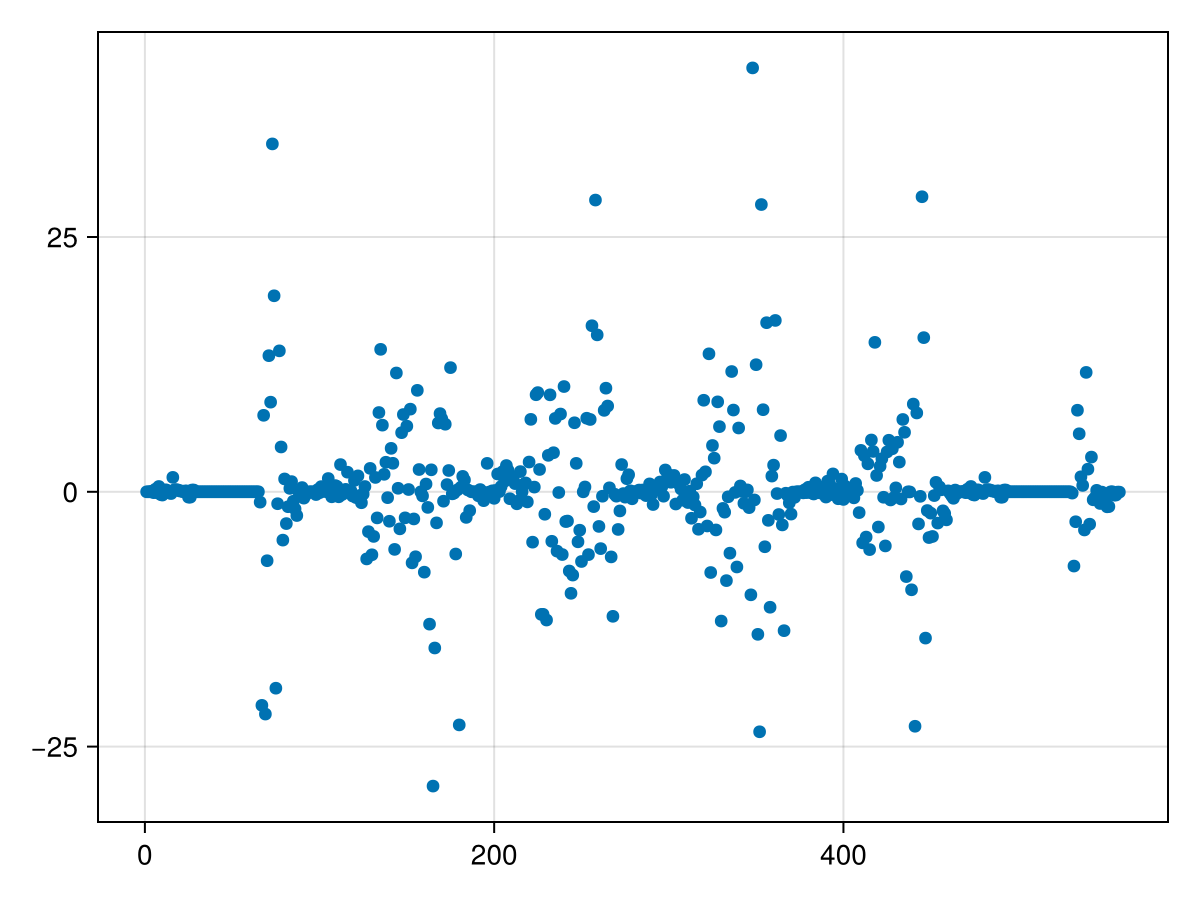

In [25]:
#Pkg.add("FileIO")
# Save full trajectory data
model = G1Humanoid()
mech = model.mech
nx, nu, dt, N = size(x_eq, 1), size(u_eq, 1), 0.2, 6
z0 = vcat([[x_eq; u_eq] for _ in 1:N]...)

equilib_foot_pos = [-0.3697416851162835, -0.1812921683831133, 0.28428794901541954]
foot_pos = equilib_foot_pos .+ [0.001, 0, -0.001]
z = optimize_trajectory_sparse(nx, nu, dt, N, x_eq, u_eq, equilib_foot_pos, foot_pos, model, z0)
CairoMakie.plot(z)
# i = 1
# for foot_pos in kick_arc
#     if i == 1
#         z0 = vcat([[x_eq; u_eq] for _ in 1:N]...)
#     else
#         traj_loaded = load("trajectory_$(i-1).jld2")
#         z0 = traj_loaded["z"]
#     end
#     println("Optimizing for index $(i), foot position: $(foot_pos)")
#     z = optimize_trajectory_sparse(nx, nu, dt, N, x_eq, u_eq, foot_pos, model, z0)
#     save("trajectory_$(i).jld2", "z", z, "traj_indices", traj_indices)
#     i += 1
# end
# Later reload
#loaded = load("trajectory.jld2")
#z_loaded = loaded["z"]
#indices_loaded = loaded["traj_indices"]